# Vader Sentiment Analysis Weekly Average
This notebook gives an average sentiment over time. You can choose between daily, weekly, or monthly depending on your dataset and needs.

For more information about how Vader works behind the scenes see here: https://github.com/cjhutto/vaderSentiment

###  Before we begin
Before we start, you will need to have set up a [Carbonate account](https://kb.iu.edu/d/aolp) in order to access [Research Desktop (ReD)](https://kb.iu.edu/d/apum). You will also need to have access to ReD through the [thinlinc client](https://kb.iu.edu/d/aput). If you have not done any of this, or have only done some of this, but not all, you should go to our [textPrep-Py.ipynb](https://github.com/cyberdh/Text-Analysis/blob/master/Intro/Python/Py_notebooks/textPrep-Py.ipynb) before you proceed further. The textPrep-Py notebook provides information and resources on how to get a Carbonate account, how to set up ReD, and how to get started using the Jupyter Notebook on ReD.   

### Run CyberDH environment
The code in the cell below points to a Python environment specificaly for use with the Python Jupyter Notebooks created by Cyberinfrastructure for Digital Humanities. It allows for the use of the different packages in our notebooks and their subsequent data sets.

##### Packages
- **sys:** Provides access to some variables used or maintained by the interpreter and to functions that interact strongly with the interpreter. It is always available.
- **os:** Provides a portable way of using operating system dependent functionality.

#### NOTE: This cell is only for use with Research Desktop. You will get an error if you try to run this cell on your personal device!!

In [1]:
import sys
import os
sys.path.insert(0,"/N/u/cyberdh/Carbonate/dhPyEnviron/lib/python3.6/site-packages")
os.environ["NLTK_DATA"] = "/N/u/cyberdh/Carbonate/dhPyEnviron/nltk_data"

### Include necessary packages for notebook 

Python's extensibility comes in large part from packages. Packages are groups of functions, data, and algorithms that allow users to easily carry out processes without recreating the wheel. Some packages are included in the basic installation of Python, others created by Python users are available for download.

In your terminal, packages can be installed by simply typing `pip install nameofpackage --user`. However, since you are using ReD and our Python environment, you will not need to install any of the packages below to use this notebook. Anytime you need to make use of a package, however, you need to import it so that Python knows to look in these packages for any functions or commands you use. Below is a brief description of the packages we are using in this notebook:    

- **nltk:** Platform for building Python programs to work with human language data. Here we bring in the VADER sentiment analysis tool which is now a part of the nltk package.

- **pandas:** An open source, BSD-licensed library providing high-performance, easy-to-use data structures and data analysis tools for the Python programming language.

- **numpy:** The fundamental package for scientific computing with Python.

- **csv:** Implements classes to read and write tabular data in CSV format.

- **json:** Used to parse and manipulate data in JSON format.

- **calendar:** Allows you to output calendars like the Unix cal program, and provides additional useful functions related to the calendar.

- **time:** Provides various time-related functions.

- **datetime:** Supplies classes for manipulating dates and times in both simple and complex ways.

- **re:** Provides regular expression matching operations similar to those found in Perl.

- **string:** contains a number of useful constants and classes, as well as some deprecated legacy functions that are also available as methods on strings.

- **glob:** Finds all the pathnames matching a specified pattern according to the rules used by the Unix shell, although results are returned in arbitrary order.

- **zipfile:** Allows for handling of zipfiles.

- **matplotlib:** A Python 2D plotting library which produces publication quality figures in a variety of hardcopy formats and interactive environments across platforms.

In [2]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pandas as pd
import numpy as np
import csv
import json
import calendar
import time
from datetime import date, timedelta
import re
import string
import glob
import zipfile
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib

### Variables
Here we create some variables for use later in our code. We do this to minimize the number and complexity of the changes you will need to make later.

First we need to decide if we want to read in one '.json' file or a whole directory of '.json' files. If you want to read in a whole directory then set `source` equal to `"*"` as this is what is called a regular expression that means 'all'. So we are reading in 'all' the files in a directory. If you wish to read in a single file then set `source` equal to the name of the desired file in quotes, but leaving the '.json' off at the end. So a single file should look like this: `source = "myFileName"`.

The remaining variables should not need to be changed. The variables `vaderScores`, `allVaderScores`, and `weeklyDates` are empty lists that will have data added to them further down in the code. The variables `vaderSum` and `weekNum` are variables used for counting which is why they are assigned to 0 since we generally start with nothing when counting. Finally, the variables `stopDate` and `currentDate` are giving the format our dates will take. The dates do not correspond to actual dates in the dataset.

In [3]:
source = "*"
vaderScores = []
allVaderScores = []
weeklyDates = []
vaderSum = 0
weekNum = 0
stopDate = date(1111,1,11)
currentDate = date(1111, 1, 1)

### File paths
Here we assign file paths we will need throughout this notebook to variables. This way we only need to make changes here and they will be implemeneted throughout the code. The `homePath` variable uses the `environ` function from the `os` package. This function points to your home directory no matter your operating system (Linux, osX, Windows).

Then we join the `homePath` variable to folders that point to where our data is stored and we assign this file path to the variable `dataHome`. The folder names are in quotes and separated by a comma. 

Finally, we again use the `homePath` variable and join it with a file path that points to a folder where we can save any output. We assign this file path to a variable called `dataResults`.

You can change any of these to better match where your data can be found (`dataHome`) and where you want any output such as '.csv' files or images to be saved (`dataResults`).

In [4]:
homePath = os.environ['HOME']
dataHome = os.path.join(homePath,'Text-Analysis-master','data','twitter')
dataResults = os.path.join(homePath, 'Text-Analysis-master', 'Output')

#### Shorten SentimentIntensityAnalyzer Function
We shorten the SentimentIntensityAnalyzer() to just 'vader' (minus the quotes).

In [5]:
vader = SentimentIntensityAnalyzer()

### Functions
We need to create a few functions in order to calculate and create a wordcloud. Any time you see `def` that means we are *DE*claring a *F*unction. The `def` is usually followed by the name of the function being created and then in parentheses are the parameters the function requires. After the parentheses is a colon, which closes the declaration, then a bunch of code below which is indented. The indented code is the program statement or statements to be executed. Once you have created your function all you need to do in order to run it is call the function by name and make sure you have included all the required parameters in the parentheses. This allows you to do what the function does without having to write out all the code in the function every time you wish to perform that task.

Here we have a number of functions. The first function, `getMonthNumber`, changes the month to a number from the three letter abreviation used in the tweet data. 

The next function, `nextWeekString`, writes out the year/month/day of the tweet. Then we get the month (`getMonthFromFile`), day (`getDayFromFile`), and year (`getYearFromFile`) from the '.json' file(s). 

Next we create a function to score the tweets with VADER (`scoreVader`), then we create a function to store data in a list (`lines2list`), and finally we have a function to return only ascii encoded text (`isAscii`). You should not need to make any changes to this part of the code.

In [6]:
def getMonthNumber(month):
    if month == "Jan":
        return 1
    elif month == "Feb":
        return 2
    elif month == "Mar":
        return 3
    elif month == "Apr":
        return 4
    elif month == "May":
        return 5
    elif month == "Jun":
        return 6
    elif month == "Jul":
        return 7
    elif month == "Aug":
        return 8
    elif month == "Sep":
        return 9
    elif month == "Oct":
        return 10
    elif month == "Nov":
        return 11
    else:
        return 12

def nextWeekString(year, month, day):
    nextDate = date(year, month, day) + timedelta(1)
    return nextDate
    
def getMonthFromFile(created_at):
    return getMonthNumber(created_at[4:7])

def getDayFromFile(created_at):
    return int(created_at[8:10])

def getYearFromFile(created_at):
    return int(created_at[26:])

#scores tweet using vader and returns the compound
def scoreVader(text):
    vs = vader.polarity_scores(text)
    return vs['compound']



def lines2list(filepath, encoding = 'utf-8', commentChar = None):
    
    with open(filepath, 'r', encoding = encoding) as f:
        lines = f.readlines()
        
        if commentChar is not None:
            lines = [x for x in lines if not x.startswith(commentChar)]
        
        # strip each line
        lines = [x.strip() for x in lines]
        
        # eliminate empty lines  
        lines = [x for x in lines if x]  
        
    return lines

def isAscii(s):
    return all(ord(c) < 128 for c in s)



### Unzip files

Here we are unzipping files. Since twitter data can be rather large it is often necessary to compress it into a '.zip' file in order to upload it to places such as GitHub. For this reason, we have setup some code to go in and automatically extract all the items in a compressed '.zip' file so you don't have to and so you don't get errors later. If the data is not in a '.zip' file there is no need to worry, it will not give an error if there are no files ending in '.zip' in your directory.

The only changes you may wish to make are in the first two lines. These are the lines that point to the file paths where your '.zip' files are stored. If you have '.zip' files stored in another folder you will want to change the path. Note that the first line points to the directory and the second line points to the files.  

In [7]:
direct = os.path.join(dataHome, "JSON")
allZipFiles = glob.glob(os.path.join(dataHome, "JSON","*.zip"))
for item in allZipFiles:
    fileName = os.path.splitext(direct)[0]
    zipRef = zipfile.ZipFile(item, "r")
    zipRef.extractall(fileName)
    zipRef.close()
    os.remove(item)

#### Read the 'text' and 'created_at' key in the JSON file

Here we read in our twitter data which is in '.json' format. The only change you may need to make is in the first line of code. We have a folder named `"JSON"` which is added to our `dataHome` variable from above to point to the sample '.json' file in that folder. If your data lies elsewhere then you will want to change `"JSON"` to the name of the folder where you data is stored. If there is a hierarchy of folders, then list each folder in quotes and separated by a comma. Leave the `source+".json"` at the end so that your `source` choice from above is added to the file path.

In [9]:
for file in glob.glob(os.path.join(dataHome, "JSON", source+".json")):
    with open(file, mode = 'r', encoding = "utf8") as read:
        #if a file starts a new week, currentDate and stopDate must be initialized
        if weekNum == 0:
            first = json.loads(next(read))
            created_at = first['created_at']
            month = getMonthFromFile(created_at)
            day = getDayFromFile(created_at)
            year = getYearFromFile(created_at)
            currentDate = date(year, month, day)
            stopDate = nextWeekString(year, month, day)
               
        for line in read:
            data = json.loads(line)
            created_at = data['created_at']
            currentMonth = getMonthFromFile(created_at)
            currentDay = getDayFromFile(created_at)
            currentYear = getYearFromFile(created_at)
            currentDate = date(currentYear, currentMonth, currentDay)
            if currentDate >= stopDate:
                vaderMean = vaderSum / weekNum
                vaderScores.append(vaderMean)
                weeklyDates.append(currentDate)
                vaderSum = 0
                weekNum = 0
                month = stopDate.month
                day = stopDate.day
                year = stopDate.year
                currentDate = date(year, month, day)
                stopDate = nextWeekString(year, month, day)
            vaderScore = scoreVader(data['text'])
            vaderSum += vaderScore
            
            allVaderScores.append(vaderScore)
            weekNum += 1
                
        
        print("Finished reading " + str(file))
        
#if there is unsaved data
if(weekNum != 0): 
    vaderMean = vaderSum / weekNum
    vaderScores.append(vaderMean)
    weeklyDates.append(currentDate)

Finished reading /N/u/klosteda/Carbonate/Text-Analysis-master/data/twitter/JSON/part-m-00000.json


#### Save results as .csv file

Here we save the dates and the scores for those dates in a '.csv' file so you have them if you need to see the exact scores later. The only thing you might need to change is what you want to name the file. This is in the first line of code. We are naming it `"vaderWeeklyScores.csv"` for now. Feel free to change it to something that better fits your data.

In [10]:
with open(os.path.join(dataResults, 'vaderWeeklyScores.csv'), "w") as write:
    writer = csv.writer(write)
    writer.writerows([vaderScores])
    writer.writerows([weeklyDates])

### Plot the graph

Here we plot the graph. We begin by assigning important parameters to variables. This allows you to make necessary changes and adjustments in one place without having to search through the code.

To start we assign some values regarding our output file to some variables. First, we assign the file name for our '.png' image output file to the variable `vaderGraphOutput`. You may wish to change the file name to better fit your dataset. Then we assign a file format to the variable `fmt`. You may change this to '.jpg' or even '.svg', but remember to change the file type in the file name assigned to `vaderGraphOutput` just before it. Now we choose the resolution of our output file and assign it to the variable `dpi`.

Next we choose a figure size and assign it to the variable `figSz`. The first number in the parantheses is the width, followed by the height.

Then we choose the date format. We currently have the format set to two digit month/two digit day/ four digit year `'%m/%d/%Y'`. You may want just month and year which would look like `'%m/%Y'`. We assign this value to the variable `dateFormat`.

Next we set the `interval` between the ticks on the x axis (bottom) of the graph. It is currently set by day, so an interval of 1 would give you a tick for every day, and interval of 7 would give you a tick for every week, and an interval of 30 would give you an interval of roughly a month. Choose an interval that best fits your dataset.

Then we choose some labels for our graph. Remember to always put the label in quotes so it is marked as a string. The `labelX` variable is where we assign a title for the x axis of the graph. The `labelY` variable is where we assign a title for the y axis (left side) of the graph. The `labelTitle` is where we assign the main title of the graph. Notice the `\n` in the title. Even though this is in quotes, Python will read this as a line break and put everything on the next line. This is helpful for longer titles.

Next we choose some font sizes. The `labelFont` is where we assign the font size for the x and y axis as well as the main title. The `tickFont` variable is where we assign the font size for the ticks on the x axis.

The `rotate` variable is where we set the angle of rotation of the x tick labels, which are the dates. We currently have the rotation set to 45 degrees, but this may not work for your dataset, so feel free to adjust it if needed.

Now we choose the dates our graph will start and end with. The format we list the date by is YYYY,M,D. This means we use the four digit year, but use the least amount of digits necessary for the month and the day, so January 2nd of 2019 would look like `beginDate = date(2019,1,2)`. We assign the date we wish the graph to begin with to the variable `beginDate` and the date we want it to end with to the variable `endDate`.

Now run the code and plot your graph!

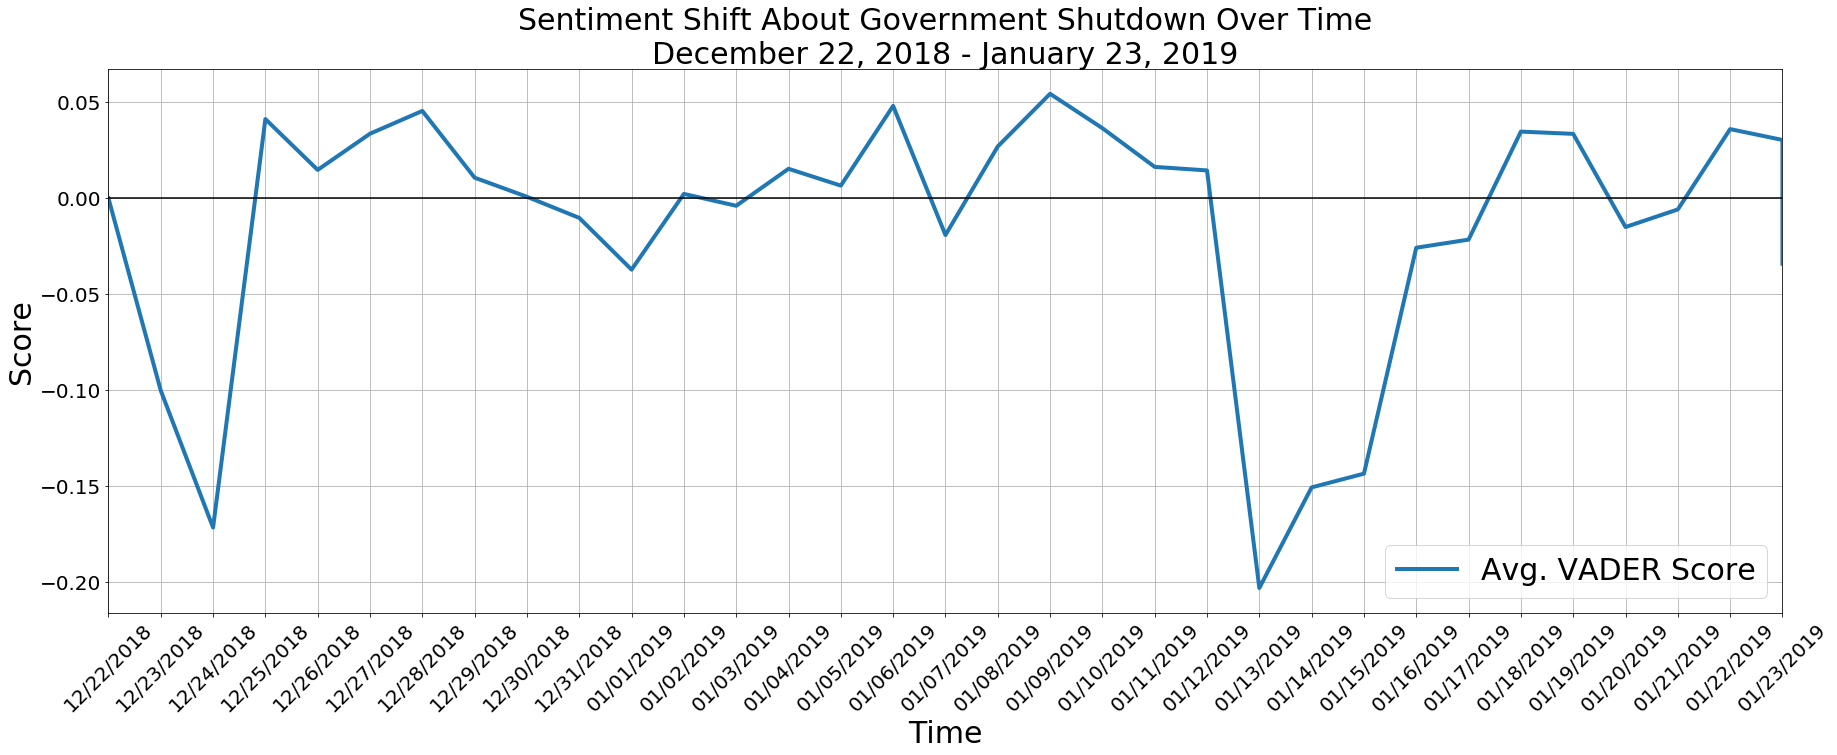

In [11]:
# Variables
vaderGraphOutput = 'vaderSentimentAvgOverTime.png'
fmt = 'png'
dpi = 300
figSz = (30,10)
dateFormat = '%m/%d/%Y'
interval = 1
labelX = 'Time'
labelY = 'Score'
labelTitle = 'Sentiment Shift About Government Shutdown Over Time\nDecember 22, 2018 - January 23, 2019'
labelFont = 30
tickFont = 20
rotate = 45
beginDate = date(2018, 12,22)
endDate = date(2019, 1, 23)


#Plot graph
fig = plt.figure(figsize=figSz)
ax = plt.subplot()
ax.plot(weeklyDates, vaderScores, label = 'Avg. VADER Score', linewidth = 4)
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter(dateFormat))
ax.xaxis.set_major_locator(mdates.DayLocator(interval = interval))
ax.grid()
ax.axhline(color = 'black')
ax.legend(loc = 4, prop = {'size':labelFont})

plt.xlabel(labelX, fontsize = labelFont)
plt.ylabel(labelY, fontsize = labelFont)
plt.title(labelTitle, fontsize = labelFont)
plt.xticks(size = tickFont, rotation = rotate)
plt.yticks(size = tickFont)
plt.xlim((beginDate, endDate))

plt.show()
fig.savefig(os.path.join(dataResults, vaderGraphOutput), format=fmt, dpi=dpi, bbox_inches='tight')

## VOILA!!

Hutto, C.J. & Gilbert, E.E. (2014). VADER: A Parsimonious Rule-based Model for Sentiment Analysis of Social Media Text. Eighth International Conference on Weblogs and Social Media (ICWSM-14). Ann Arbor, MI, June 2014.